In [68]:
"""
===-*- Statistical Analysis Tool -*-===
=====-*- General -*-=====
Copyright (c) makkiblog.com
MIT License 
coding: utf-8

===-*- VERSION -*-===
v0.0 Initial Release
vvvCODEvvv
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Set up better plotting defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

# Statistical Process Control Function Definitions

In [69]:
class ProcessControl:
    def __init__(self):
        """Initialize the process control environment."""
        self.data = None
        self.spec_limits = {}
        self.distribution_fits = {}
        self.active_column = None
        
    def load_data(self, data, column=None):
        """Load process data into the environment.
        
        Parameters:
        -----------
        data : pandas.DataFrame or numpy.array
            Process data to analyze
        column : str, optional
            If data is DataFrame, specify column to analyze
        """
        if isinstance(data, pd.DataFrame):
            self.data = data
            if column is not None:
                if column in self.data.columns:
                    self.active_column = column
                else:
                    raise ValueError(f"Column '{column}' not found in DataFrame")
            elif len(data.columns) > 0:
                # Set the first column as active by default
                self.active_column = data.columns[0]
                print(f"No column specified. Using '{self.active_column}' as the active column.")
            else:
                raise ValueError("DataFrame has no columns")
        else:
            # Handle numpy array or other array-like data
            self.data = pd.DataFrame({'data': np.array(data)})
            self.active_column = 'data'
    
    def set_active_column(self, column):
        """Set the active column for analysis.
        
        Parameters:
        -----------
        column : str
            Column name to use for analysis
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if column in self.data.columns:
            self.active_column = column
        else:
            raise ValueError(f"Column '{column}' not found in data")
    
    def get_column_data(self):
        """Get the active column data for analysis."""
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if self.active_column is None:
            raise ValueError("No active column set. Use set_active_column() first.")
            
        return self.data[self.active_column].values
            
    def set_specification_limits(self, usl, lsl, target=None):
        """Set specification limits for capability analysis.
        
        Parameters:
        -----------
        usl : float
            Upper specification limit
        lsl : float
            Lower specification limit
        target : float, optional
            Target value for process
        """
        self.spec_limits = {
            'USL': usl,
            'LSL': lsl,
            'Target': target
        }


    def calculate_capability(self):
        """Calculate additional process capability indices (Pp, Ppk, Cpm, Cpkm).
        
        Returns:
        --------
        dict
            Dictionary containing capability indices
        """
        if not self.spec_limits:
            raise ValueError("Specification limits not set")
            
        data = self.get_column_data()
        mean = np.mean(data)
        std = np.std(data)

        # Calculate Cp
        cp = (self.spec_limits['USL'] - self.spec_limits['LSL']) / (6 * std)
        
        # Calculate Cpk
        cpu = (self.spec_limits['USL'] - mean) / (3 * std)
        cpl = (mean - self.spec_limits['LSL']) / (3 * std)
        cpk = min(cpu, cpl)
        
        # Calculate Pp and Ppk
        pp = (self.spec_limits['USL'] - self.spec_limits['LSL']) / (6 * std)
        ppk = min((self.spec_limits['USL'] - mean) / (3 * std), (mean - self.spec_limits['LSL']) / (3 * std))
        
        # Calculate Cpm and Cpkm
        if self.spec_limits['Target']:
            cpm = (self.spec_limits['USL'] - self.spec_limits['LSL']) / (6 * np.sqrt(std**2 + (mean - self.spec_limits['Target'])**2))
            cpkm = min((self.spec_limits['USL'] - mean) / (3 * np.sqrt(std**2 + (mean - self.spec_limits['Target'])**2)),
                       (mean - self.spec_limits['LSL']) / (3 * np.sqrt(std**2 + (mean - self.spec_limits['Target'])**2)))
        else:
            cpm = None
            cpkm = None
        
        return {
            'Cp': cp,
            'Cpk': cpk,
            'Cpu': cpu,
            'Cpl': cpl,
            'Pp': pp,
            'Ppk': ppk,
            'Cpm': cpm,
            'Cpkm': cpkm
        }
        

    def fit_distribution(self, distribution='normal'):
        """Fit data to specified distribution.
        
        Parameters:
        -----------
        distribution : str
            Distribution type ('normal', 'weibull', or 'lognormal')
            
        Returns:
        --------
        dict
            Dictionary containing distribution parameters and fit statistics
        """
        data = self.get_column_data()
        
        if distribution.lower() == 'normal':
            params = stats.norm.fit(data)
            dist = stats.norm(*params)
        elif distribution.lower() == 'weibull':
            params = stats.weibull_min.fit(data, floc=0)
            dist = stats.weibull_min(*params)
        elif distribution.lower() == 'lognormal':
            # For lognormal, we need to handle the parameterization
            # s is the shape parameter (standard deviation of the log of the data)
            # scale is exp(mean of the log of the data)
            params = stats.lognorm.fit(data, floc=0)
            dist = stats.lognorm(*params)
            
            # Add some useful derived parameters for interpretation
            shape_s = params[0]  # s parameter (sigma)
            scale = params[2]    # scale parameter (exp(mu))
            
            # Calculate mu and sigma of the underlying normal distribution
            mu = np.log(scale)
            sigma = shape_s
            
            # Add these to the params for easier interpretation
            params = (*params, mu, sigma)
        else:
            raise ValueError("Unsupported distribution. Choose 'normal', 'weibull', or 'lognormal'")
            
        # Calculate fit statistics
        ks_stat, ks_p = stats.kstest(data, dist.cdf)
        
        return {
            'distribution': distribution,
            'parameters': params,
            'ks_stat': ks_stat,
            'ks_p': ks_p,
            'distribution_obj': dist
        }

    def plot_distribution(self, distribution_fit=None):
        """Create histogram with fitted distribution overlay.
        
        Parameters:
        -----------
        distribution_fit : dict, optional
            Distribution fit results from fit_distribution()
        """
        data = self.get_column_data()
        plt.figure()
        
        # Plot histogram
        sns.histplot(data, stat='density', alpha=0.6, label='Data', color='#4472C4')
        
        # Plot fitted distribution if provided
        if distribution_fit:
            x = np.linspace(min(data), max(data), 1000)
            y = distribution_fit['distribution_obj'].pdf(x)
            plt.plot(x, y, 'r-', label=f"Fitted {distribution_fit['distribution']}")
            
            # Add distribution parameters to the plot
            if distribution_fit['distribution'].lower() == 'normal':
                mu, sigma = distribution_fit['parameters']
                param_text = f"μ = {mu:.4f}, σ = {sigma:.4f}"
            elif distribution_fit['distribution'].lower() == 'weibull':
                c, loc, scale = distribution_fit['parameters']
                param_text = f"c = {c:.4f}, scale = {scale:.4f}"
            elif distribution_fit['distribution'].lower() == 'lognormal':
                s, loc, scale, mu, sigma = distribution_fit['parameters']
                param_text = f"μ_log = {mu:.4f}, σ_log = {sigma:.4f}"
            else:
                param_text = f"params = {distribution_fit['parameters']}"
                
            plt.annotate(param_text, xy=(0.05, 0.95), xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.title(f'Process Distribution Analysis: {self.active_column}')
        if distribution_fit:
            plt.title(f'Process Distribution Analysis: {self.active_column} - {distribution_fit["distribution"]}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()
            
    def plot_capability(self):
        """Create capability plot showing process distribution and limits."""
        data = self.get_column_data()
        
        plt.figure()
        
        # Plot histogram
        sns.histplot(data, stat='density', alpha=0.6, label='Data', color='#4472C4')
        
        # Plot normal distribution fit
        mean = np.mean(data)
        std = np.std(data)
        x = np.linspace(min(data), max(data), 100)
        y = stats.norm.pdf(x, mean, std)
        plt.plot(x, y, 'r-', label='Normal Fit')
        
        # Add specification limits
        if self.spec_limits:
            plt.axvline(x=self.spec_limits['USL'], color='red', linestyle='--', label='USL')
            plt.axvline(x=self.spec_limits['LSL'], color='red', linestyle='--', label='LSL')
            if self.spec_limits['Target']:
                plt.axvline(x=self.spec_limits['Target'], color='green', linestyle='-', label='Target')
        
        plt.title(f'Process Capability Analysis: {self.active_column}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
        plt.tight_layout()
        plt.show()
        
    def calculate_correlation(self, x_column, y_column):
        """Calculate correlation between two columns.
        
        Parameters:
        -----------
        x_column : str
            Name of the first column
        y_column : str
            Name of the second column
            
        Returns:
        --------
        tuple
            (correlation coefficient, p-value)
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if x_column not in self.data.columns:
            raise ValueError(f"Column '{x_column}' not found in data")
            
        if y_column not in self.data.columns:
            raise ValueError(f"Column '{y_column}' not found in data")
            
        # Calculate Pearson correlation coefficient and p-value
        corr, p_value = stats.pearsonr(self.data[x_column], self.data[y_column])
        
        return corr, p_value
    
    def plot_correlation(self, x_column, y_column, add_line=True):
        """Create a scatter plot to visualize correlation between two columns.
        
        Parameters:
        -----------
        x_column : str
            Name of the column for x-axis
        y_column : str
            Name of the column for y-axis
        add_line : bool, optional
            Whether to add a best fit line (default: True)
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if x_column not in self.data.columns:
            raise ValueError(f"Column '{x_column}' not found in data")
            
        if y_column not in self.data.columns:
            raise ValueError(f"Column '{y_column}' not found in data")
        
        # Calculate correlation for the title
        corr, p_value = self.calculate_correlation(x_column, y_column)
        
        if add_line:
            # Create scatter plot with regression line
            plt.figure(figsize=(10, 6))
            ax = sns.regplot(x=x_column, y=y_column, data=self.data, scatter_kws={'alpha':0.6})
            plt.title(f'Correlation between {x_column} and {y_column}\nr = {corr:.4f}, p = {p_value:.4e}')
        else:
            # Create simple scatter plot
            plt.figure(figsize=(10, 6))
            ax = sns.scatterplot(x=x_column, y=y_column, data=self.data, alpha=0.6)
            plt.title(f'Scatter plot: {x_column} vs {y_column}\nr = {corr:.4f}, p = {p_value:.4e}')
            
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.tight_layout()
        plt.show()
        
    def correlation_matrix(self, columns=None):
        """Calculate and return the correlation matrix for selected columns.
        
        Parameters:
        -----------
        columns : list, optional
            List of column names to include in the correlation matrix.
            If None, all numeric columns are used.
            
        Returns:
        --------
        pandas.DataFrame
            Correlation matrix
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if columns is not None:
            # Check if all specified columns exist
            missing_cols = [col for col in columns if col not in self.data.columns]
            if missing_cols:
                raise ValueError(f"Columns not found in data: {missing_cols}")
            
            # Select only the specified columns
            data_subset = self.data[columns]
        else:
            # Use all numeric columns
            data_subset = self.data.select_dtypes(include=['number'])
            
        # Calculate correlation matrix
        corr_matrix = data_subset.corr()
        
        return corr_matrix
    
    def plot_correlation_matrix(self, columns=None):
        """Plot a heatmap of the correlation matrix.
        
        Parameters:
        -----------
        columns : list, optional
            List of column names to include in the correlation matrix.
            If None, all numeric columns are used.
        """
        corr_matrix = self.correlation_matrix(columns)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()


    def plot_normal_probability(self, column):
        """Create a normal probability plot for a given column with sigma reference points.
        
        Parameters:
        -----------
        column : str
            Name of the column to plot
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if column not in self.data.columns:
            raise ValueError(f"Column '{column}' not found in data")
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # Generate the probability plot
        result = stats.probplot(self.data[column], plot=ax)
        
        # Extract the results
        (osm, osr), (slope, intercept, r) = result
        
        # Find the closest points to sigma = -1, 0, and 1
        sigma_values = [-1, 0, 1]
        sigma_indices = []
        
        for sigma in sigma_values:
            # Find the index of the closest theoretical quantile to our sigma value
            closest_idx = np.abs(osm - sigma).argmin()
            sigma_indices.append(closest_idx)
        
        # Add annotations for these points
        for i, sigma in zip(sigma_indices, sigma_values):
            x_val = osm[i]
            y_val = osr[i]
            ax.plot(x_val, y_val, 'ro', markersize=8)  # Red circle marker
            ax.annotate(f'σ={sigma}: {y_val:.2f}', 
                       xy=(x_val, y_val),
                       xytext=(x_val + 0.2, y_val),
                       arrowprops=dict(arrowstyle="->", color='red'),
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
        
        # Print the values to console as well
        print(f"Ordered values at reference points:")
        for i, sigma in zip(sigma_indices, sigma_values):
            print(f"σ = {sigma}: {osr[i]:.4f} (theoretical quantile = {osm[i]:.4f})")
        
        # Add title with correlation coefficient
        ax.set_title(f'Normal Probability Plot for {column}\nr = {r:.4f}')
        ax.set_xlabel('Theoretical Quantiles (σ)')
        ax.set_ylabel('Ordered Values')
        
        # Add a legend explaining the plot
        textstr = '\n'.join([
            'Reference Points:',
            f'σ = -1: {osr[sigma_indices[0]]:.2f}',
            f'σ = 0: {osr[sigma_indices[1]]:.2f}',
            f'σ = 1: {osr[sigma_indices[2]]:.2f}'
        ])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.show()
    
    def tolerance_interval(self, alpha=0.05, p=0.95, distribution='normal'):
        """Calculate tolerance interval for the specified distribution.
        
        Parameters:
        -----------
        alpha : float, optional
            Significance level (default: 0.05)
        p : float, optional
            Proportion of the population to be covered (default: 0.95)
        distribution : str, optional
            Distribution type ('normal' or 'weibull') (default: 'normal')
            
        Returns:
        --------
        tuple
            Lower and upper bounds of the tolerance interval
        """
        data = self.get_column_data()
        n = len(data)
        
        if distribution.lower() == 'normal':
            mean = np.mean(data)
            std = np.std(data)
            k = stats.norm.ppf(1 - alpha / 2) * np.sqrt((n - 1) / stats.chi2.ppf(p, n - 1))
            lower = mean - k * std
            upper = mean + k * std
        elif distribution.lower() == 'weibull':
            params = stats.weibull_min.fit(data, floc=0)
            lower = stats.weibull_min.ppf(alpha / 2, *params)
            upper = stats.weibull_min.ppf(1 - alpha / 2, *params)
        else:
            raise ValueError("Unsupported distribution")
            
        return lower, upper

## MultiVariate Analysis Definition

In [70]:
class MultivariateAnalysis:
    def __init__(self, data):
        """Initialize the multivariate analysis with the given data.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input data for multivariate analysis
        """
        self.data = data
        
    def principal_component_analysis(self, n_components=None):
        """Perform Principal Component Analysis (PCA) on the data.
        
        Parameters:
        -----------
        n_components : int, optional
            Number of principal components to retain (default: None)
            
        Returns:
        --------
        tuple
            Principal components and explained variance ratio
        """
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(self.data)
        explained_variance_ratio = pca.explained_variance_ratio_
        
        return principal_components, explained_variance_ratio
    
    def partial_least_squares(self, X, y, n_components=None):
        """Perform Partial Least Squares (PLS) regression on the data.
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Input features
        y : pandas.Series
            Target variable
        n_components : int, optional
            Number of PLS components to retain (default: None)
            
        Returns:
        --------
        sklearn.cross_decomposition.PLSRegression
            Fitted PLS regression model
        """
        pls = PLSRegression(n_components=n_components)
        pls.fit(X, y)
        
        return pls

## Statistical Test Definition

In [71]:
class StatisticalTests:
    def __init__(self, data):
        """Initialize the statistical tests with the given data.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input data for statistical tests
        """
        self.data = data
        
    def mann_whitney_u_test(self, group1, group2):
        """Perform Mann-Whitney U test on two independent groups.
        
        Parameters:
        -----------
        group1 : pandas.Series
            First group of observations
        group2 : pandas.Series
            Second group of observations
            
        Returns:
        --------
        tuple
            Mann-Whitney U statistic and p-value
        """
        u_stat, p_value = stats.mannwhitneyu(group1, group2)
        
        return u_stat, p_value
    
    def kruskal_wallis_test(self, *groups):
        """Perform Kruskal-Wallis test on multiple independent groups.
        
        Parameters:
        -----------
        *groups : pandas.Series
            Multiple groups of observations
            
        Returns:
        --------
        tuple
            Kruskal-Wallis H statistic and p-value
        """
        h_stat, p_value = stats.kruskal(*groups)
        
        return h_stat, p_value
    
    def moods_median_test(self, *groups):
        """Perform Mood's median test on multiple independent groups.
        
        Parameters:
        -----------
        *groups : pandas.Series
            Multiple groups of observations
            
        Returns:
        --------
        tuple
            Mood's chi-square statistic and p-value
        """
        chi2_stat, p_value, _, _ = stats.median_test(*groups)
        
        return chi2_stat, p_value



## Visualization Definitions

In [72]:
class Visualization:
    def __init__(self, data):
        """Initialize the visualization with the given data.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input data for visualization
        """
        self.data = data
        
    def multi_vari_chart(self, group_column, value_column):
        """Create a multi-vari chart to visualize the distribution of a value across groups.
        
        Parameters:
        -----------
        group_column : str
            Column name representing the groups
        value_column : str
            Column name representing the values to be plotted
        """
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=group_column, y=value_column, data=self.data)
        plt.title(f'Multi-Vari Chart: {value_column} by {group_column}')
        plt.xlabel(group_column)
        plt.ylabel(value_column)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def box_plot(self, column):
        """Create a box plot to visualize the distribution of a column.
        
        Parameters:
        -----------
        column : str
            Column name to be plotted
        """
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=column, data=self.data)
        plt.title(f'Box Plot: {column}')
        plt.xlabel(column)
        plt.tight_layout()
        plt.show()
        
    def pareto_chart(self, category_column, value_column):
        """Create a Pareto chart to visualize the distribution of values across categories.
        
        Parameters:
        -----------
        category_column : str
            Column name representing the categories
        value_column : str
            Column name representing the values to be plotted
        """
        data_sorted = self.data.sort_values(by=value_column, ascending=False)
        cumulative_percentage = data_sorted[value_column].cumsum() / data_sorted[value_column].sum() * 100
        
        plt.figure(figsize=(10, 6))
        ax1 = sns.barplot(x=category_column, y=value_column, data=data_sorted)
        ax2 = ax1.twinx()
        ax2.plot(ax1.get_xticks(), cumulative_percentage, marker='o', color='red')
        
        ax1.set_xlabel(category_column)
        ax1.set_ylabel(value_column)
        ax2.set_ylabel('Cumulative Percentage')
        
        plt.title(f'Pareto Chart: {value_column} by {category_column}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        

## Define Read csv

In [73]:
def read_csv_data(file_path, column=None):
    data = pd.read_csv(file_path)
    pc = ProcessControl()
    pc.load_data(data, column)
    return pc

# Sample Execution

In [74]:
# Read data from CSV
pc = read_csv_data('./Sample_Inputfile/sample_manufacturing_data.csv', 'Temperature')

# Display available columns
print("Available columns in the dataset:")
print(pc.data.columns.tolist())

# Set specification limits
pc.set_specification_limits(usl=26.0, lsl=24.0, target=25.0)

Available columns in the dataset:
['Temperature', 'Pressure', 'Flow_Rate', 'Corrected_Flowrate', 'Diam', 'Test_Bench']


## Capability Analysis


Process Capability Analysis Results for Temperature:
Cp: 1.229
Cpk: 1.190
Cpm: 1.221
Cpkm: 1.182

Distribution Fit Results for Temperature:

Normal Distribution:
Parameters: (24.9686, 0.2713)
KS-statistic: 0.052
KS-p-value: 0.937

Weibull Distribution:
Parameters: (98.8402, 0.0000)
KS-statistic: 0.105
KS-p-value: 0.207


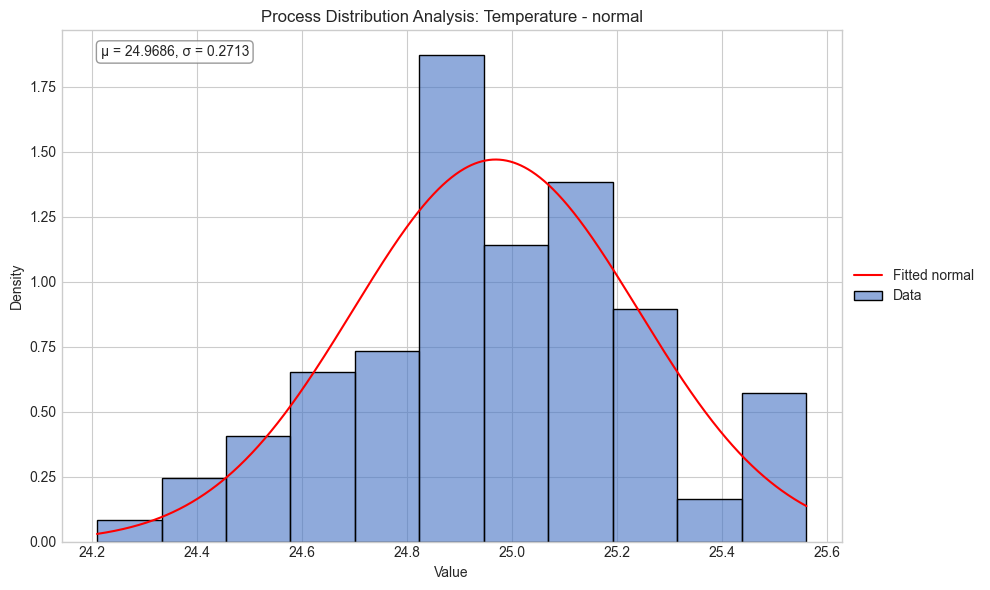

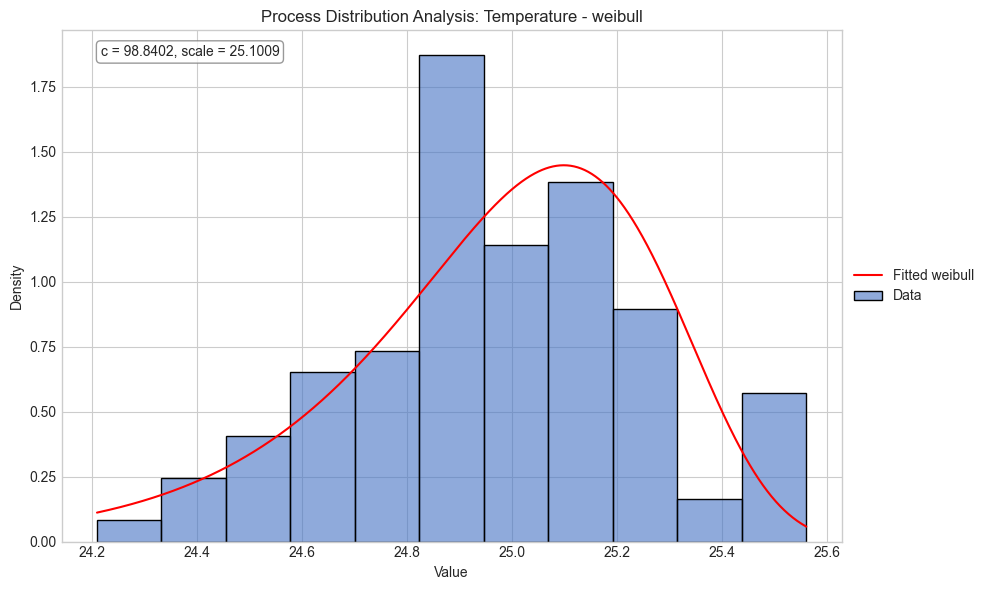

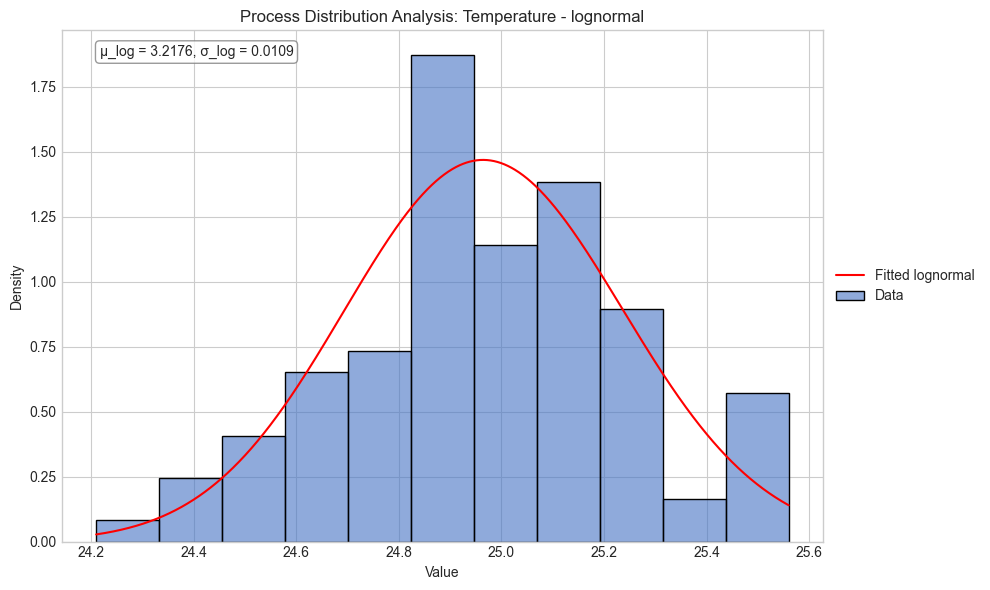

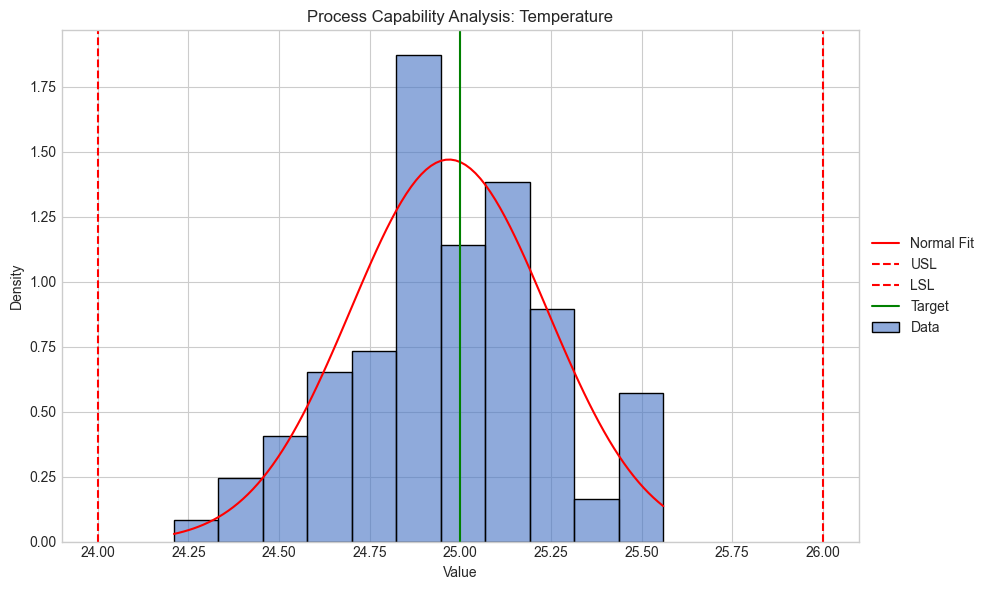


Principal Component Analysis Results:
Explained Variance Ratio: [0.93081442 0.06820323]

Mann-Whitney U Test Results:
U-statistic: 1035.5
p-value: 0.140


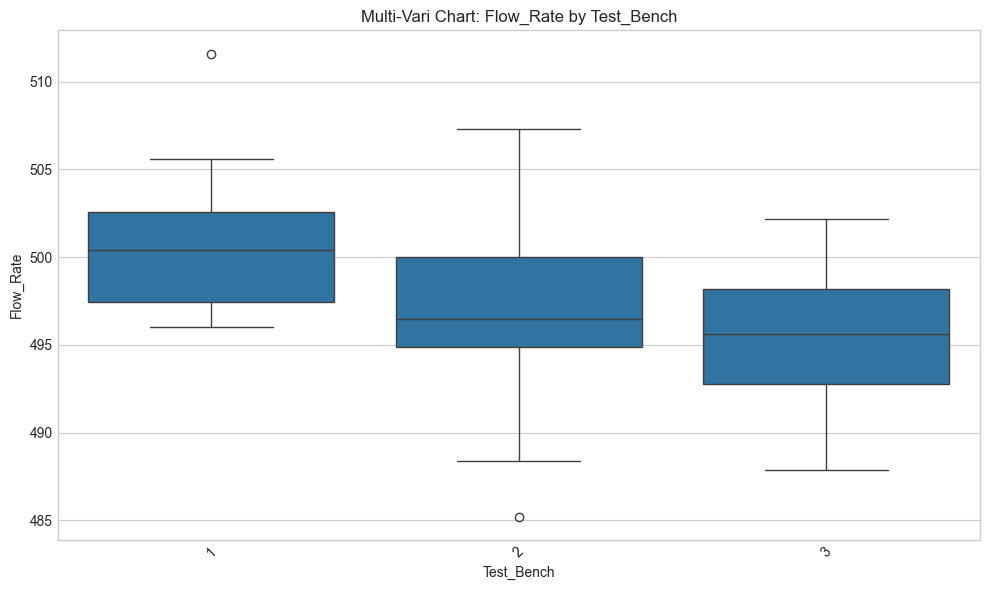

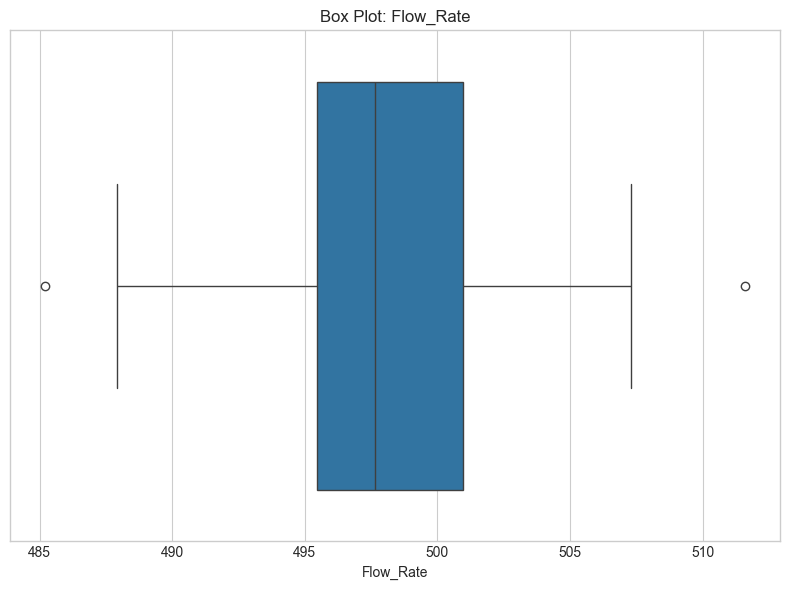

In [75]:
# Perform capability analysis on Temperature
pc.set_active_column('Temperature')


capability_results = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Temperature:")
print(f"Cp: {capability_results['Cp']:.3f}")
print(f"Cpk: {capability_results['Cpk']:.3f}")
print(f"Cpm: {capability_results['Cpm']:.3f}")
print(f"Cpkm: {capability_results['Cpkm']:.3f}")

# Fit and compare distributions
normal_fit = pc.fit_distribution('normal')
weibull_fit = pc.fit_distribution('weibull')
lognormal_fit = pc.fit_distribution('lognormal')

print("\nDistribution Fit Results for Temperature:")
print("\nNormal Distribution:")
#print(f"Parameters: {normal_fit['parameters']:}")
params = normal_fit['parameters']
print(f"Parameters: ({params[0]:.4f}, {params[1]:.4f})")
print(f"KS-statistic: {normal_fit['ks_stat']:.3f}")
print(f"KS-p-value: {normal_fit['ks_p']:.3f}")

print("\nWeibull Distribution:")
#print(f"Parameters: {weibull_fit['parameters']:}")
params = weibull_fit['parameters']
print(f"Parameters: ({params[0]:.4f}, {params[1]:.4f})")
print(f"KS-statistic: {weibull_fit['ks_stat']:.3f}")
print(f"KS-p-value: {weibull_fit['ks_p']:.3f}")

# Create visualizations for Temperature
pc.plot_distribution(normal_fit)
pc.plot_distribution(weibull_fit)
pc.plot_distribution(lognormal_fit)
pc.plot_capability()

# Perform multivariate analysis
mv_analysis = MultivariateAnalysis(pc.data)
principal_components, explained_variance = mv_analysis.principal_component_analysis(n_components=2)
print("\nPrincipal Component Analysis Results:")
#print(f"Principal Components:\n{principal_components}")
print(f"Explained Variance Ratio: {explained_variance}")

# Perform statistical tests
stats_tests = StatisticalTests(pc.data)
group1 = pc.data['Temperature'][:50]
group2 = pc.data['Temperature'][50:]
u_stat, p_value = stats_tests.mann_whitney_u_test(group1, group2)
print("\nMann-Whitney U Test Results:")
print(f"U-statistic: {u_stat}")
print(f"p-value: {p_value:.3f}")

# Create additional visualizations
viz = Visualization(pc.data)
viz.multi_vari_chart('Test_Bench', 'Flow_Rate')
viz.box_plot('Flow_Rate')
#viz.pareto_chart('Group', 'Value')


Process Capability Analysis Results for Pressure:
Cp: 0.115
Cpk: -8.227
Cpm: 0.005
Cpkm: -0.328

Distribution Fit Results for Pressure:

Normal Distribution:
Parameters: (97.4190, 2.8937)
KS-statistic: 0.068
KS-p-value: 0.721


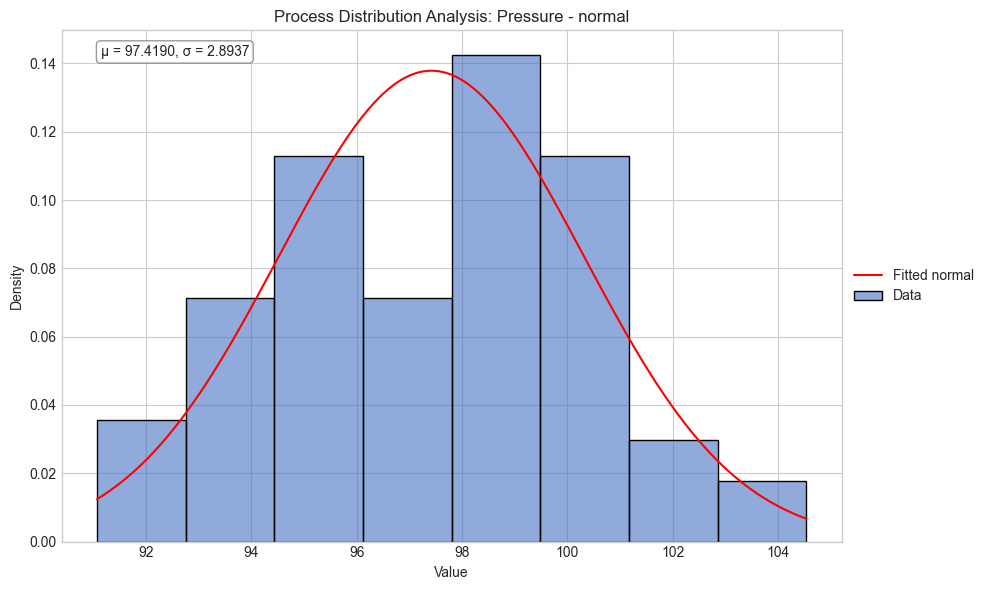

In [76]:
# Perform capability analysis on Pressure
pc.set_active_column('Pressure')


capability_results = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Pressure:")
print(f"Cp: {capability_results['Cp']:.3f}")
print(f"Cpk: {capability_results['Cpk']:.3f}")
print(f"Cpm: {capability_results['Cpm']:.3f}")
print(f"Cpkm: {capability_results['Cpkm']:.3f}")

# Fit and compare distributions
normal_fit = pc.fit_distribution('normal')

print("\nDistribution Fit Results for Pressure:")
print("\nNormal Distribution:")
#print(f"Parameters: {normal_fit['parameters']:}")
params = normal_fit['parameters']
print(f"Parameters: ({params[0]:.4f}, {params[1]:.4f})")
print(f"KS-statistic: {normal_fit['ks_stat']:.3f}")
print(f"KS-p-value: {normal_fit['ks_p']:.3f}")

pc.plot_distribution(normal_fit)


Process Capability Analysis Results for Corrected_Flowrate:
Cp: -0.423
Cpk: -0.460
Cpm: -0.420
Cpkm: -0.457


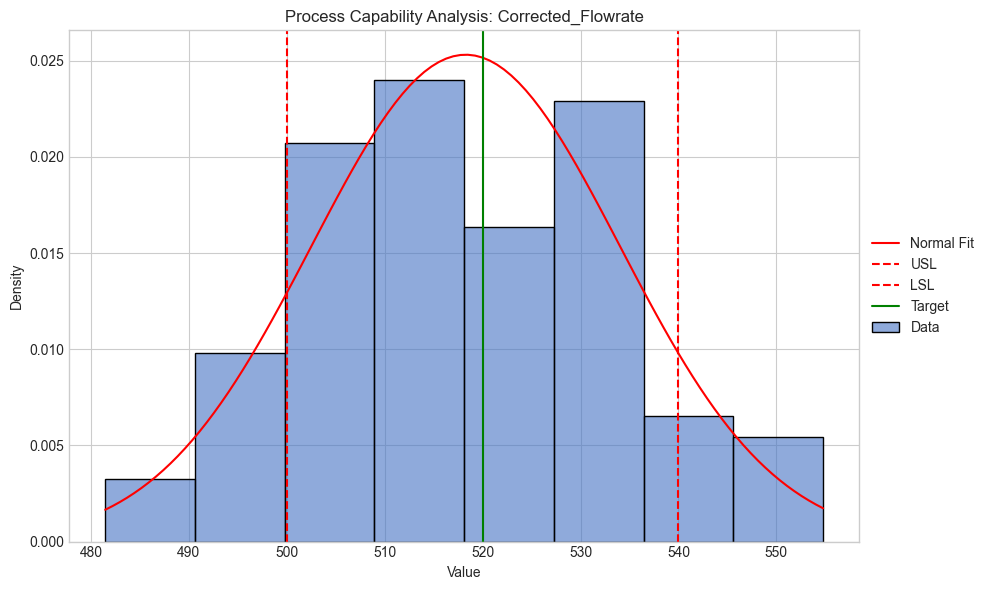


Process Capability Analysis Results for Diam:
Cp: 0.456
Cpk: 0.257
Cpm: 0.391
Cpkm: 0.220


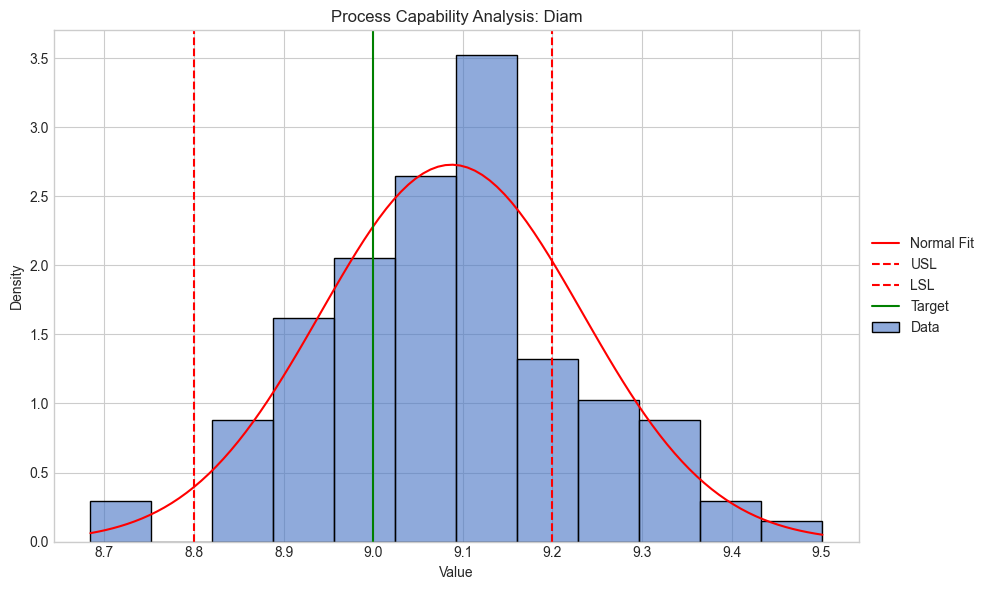

In [79]:
# Switch to another column for analysis
pc.set_active_column('Corrected_Flowrate')

# Set specification limits for Pressure
pc.set_specification_limits(usl=500.0, lsl=540.0, target=520.0)

# Perform capability analysis on Flow Rate
flow_capability = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Corrected_Flowrate:")
print(f"Cp: {flow_capability['Cp']:.3f}")
print(f"Cpk: {flow_capability['Cpk']:.3f}")
print(f"Cpm: {flow_capability['Cpm']:.3f}")
print(f"Cpkm: {flow_capability['Cpkm']:.3f}")

# Plot capability for Flow Rate
pc.plot_capability()


# Switch to another column for analysis
pc.set_active_column('Diam')

# Set specification limits for Diam
pc.set_specification_limits(usl=9.2, lsl=8.8, target=9.0)

# Perform capability analysis on Diam
flow_capability = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Diam:")
print(f"Cp: {flow_capability['Cp']:.3f}")
print(f"Cpk: {flow_capability['Cpk']:.3f}")
print(f"Cpm: {flow_capability['Cpm']:.3f}")
print(f"Cpkm: {flow_capability['Cpkm']:.3f}")

# Plot capability for Diam
pc.plot_capability()

## Correlation Matrix


Correlation between Temperature and Pressure:
Correlation coefficient: 0.1402
p-value: 1.6422e-01

Analyzing correlations between: ['Temperature', 'Pressure', 'Flow_Rate', 'Corrected_Flowrate', 'Diam']


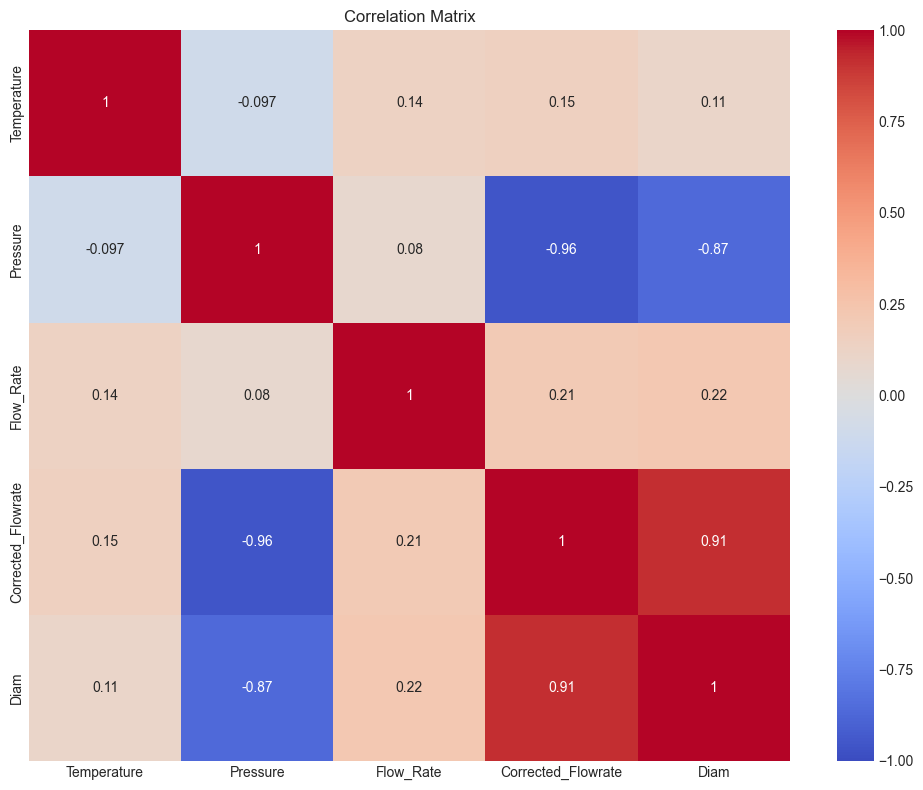

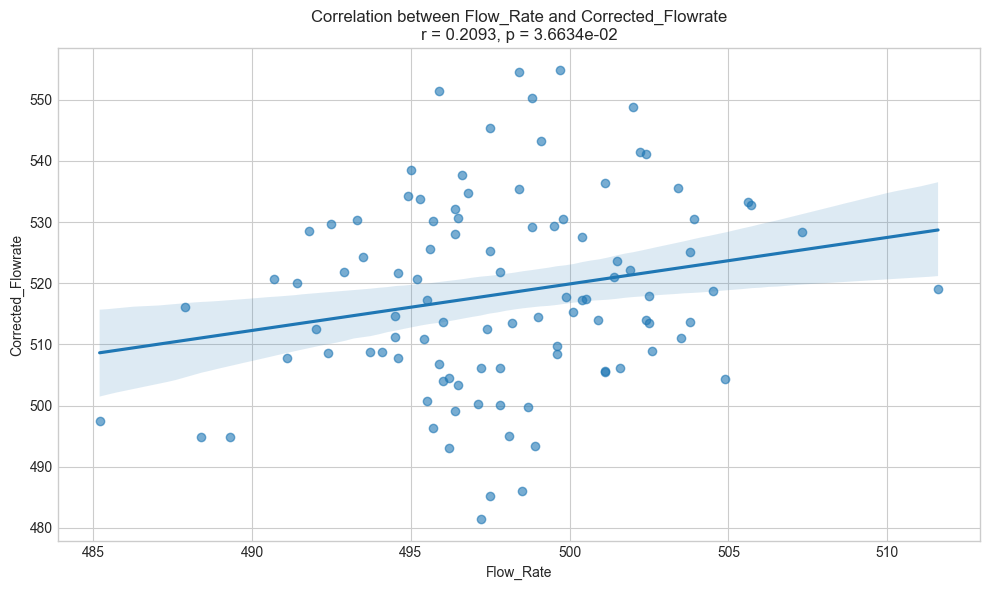

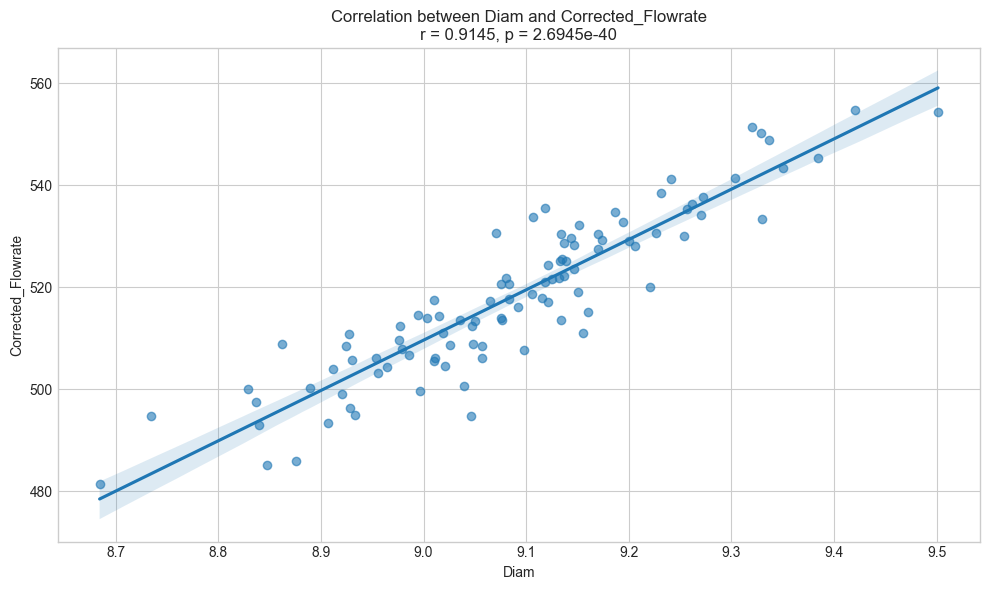

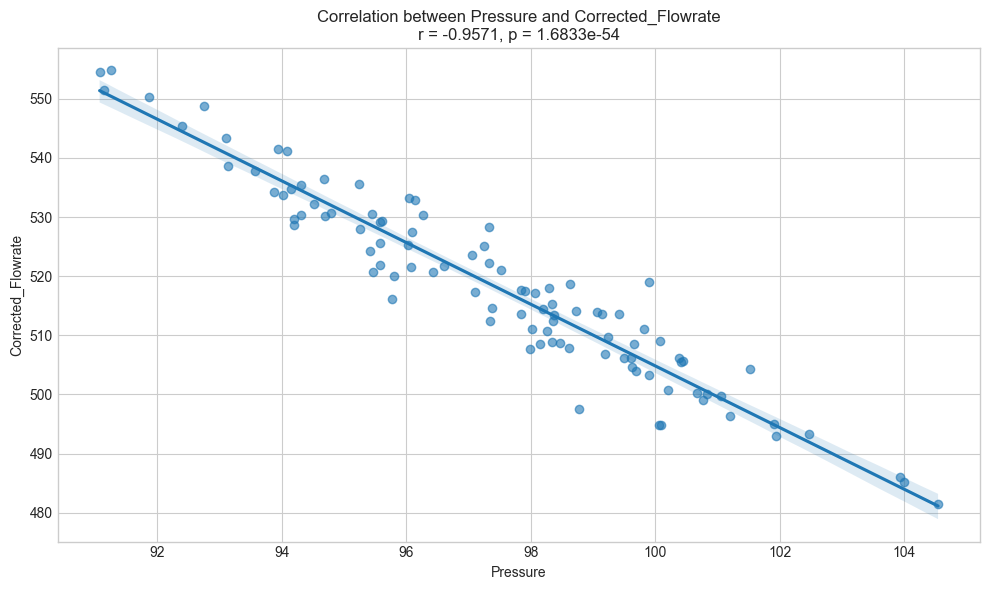

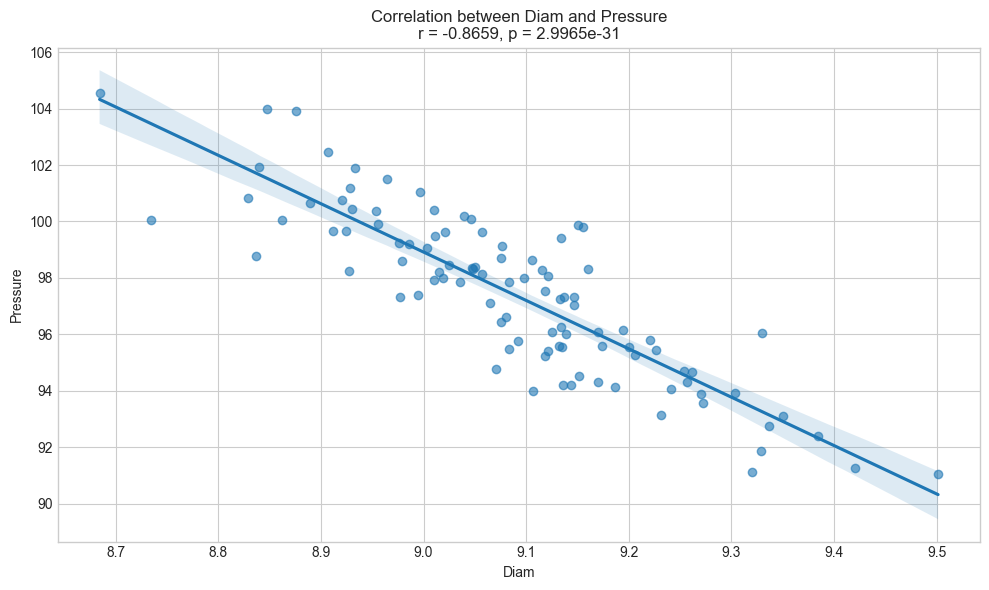

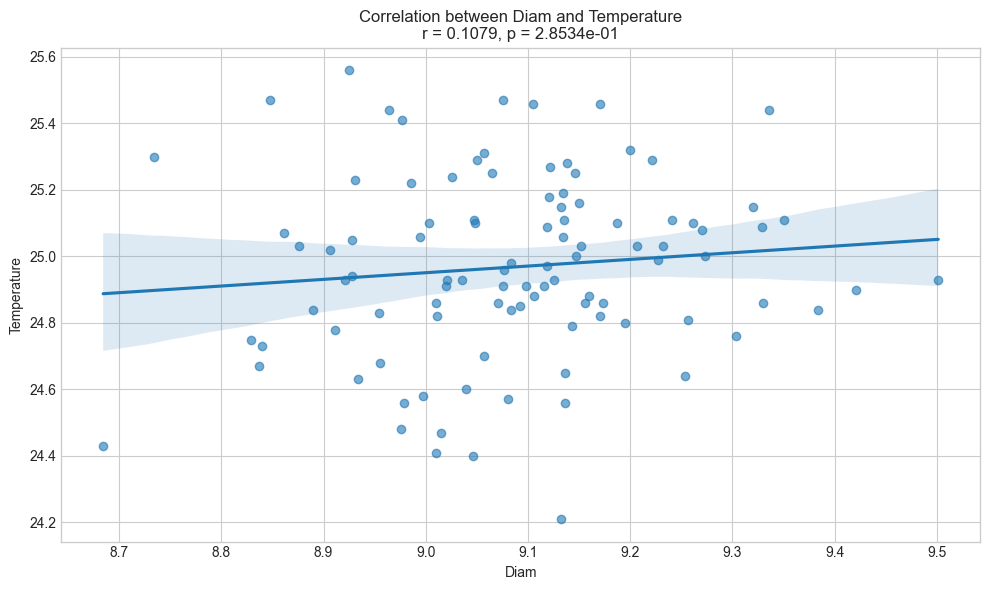

Ordered values at reference points:
σ = -1: 24.6800 (theoretical quantile = -1.0100)
σ = 0: 24.9600 (theoretical quantile = -0.0125)
σ = 1: 25.2500 (theoretical quantile = 1.0100)


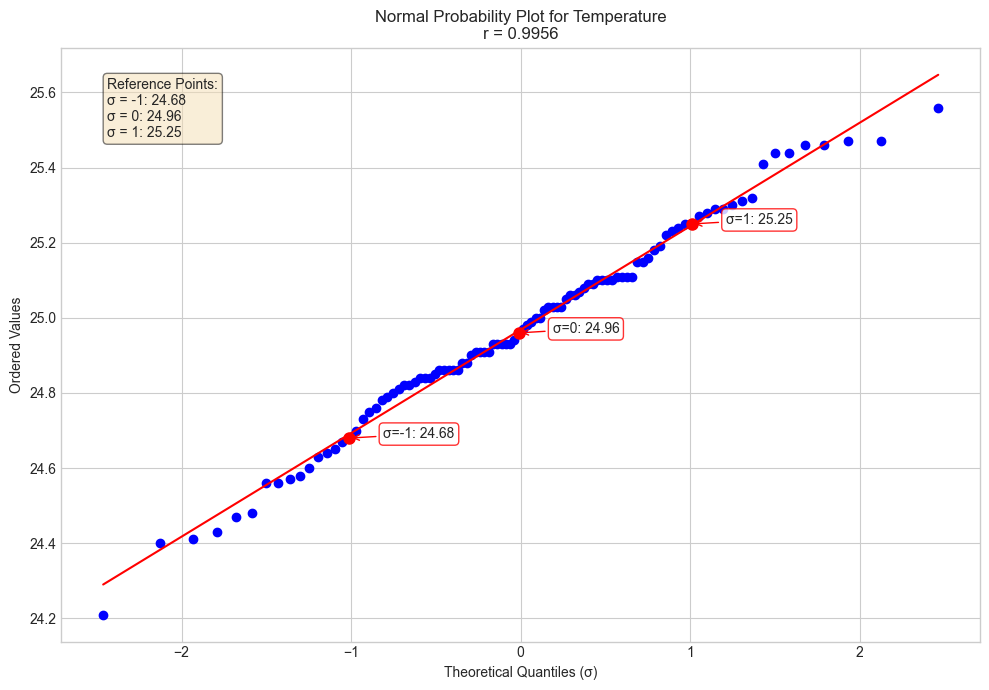

Ordered values at reference points:
σ = -1: 94.2000 (theoretical quantile = -1.0100)
σ = 0: 97.8400 (theoretical quantile = -0.0125)
σ = 1: 100.2000 (theoretical quantile = 1.0100)


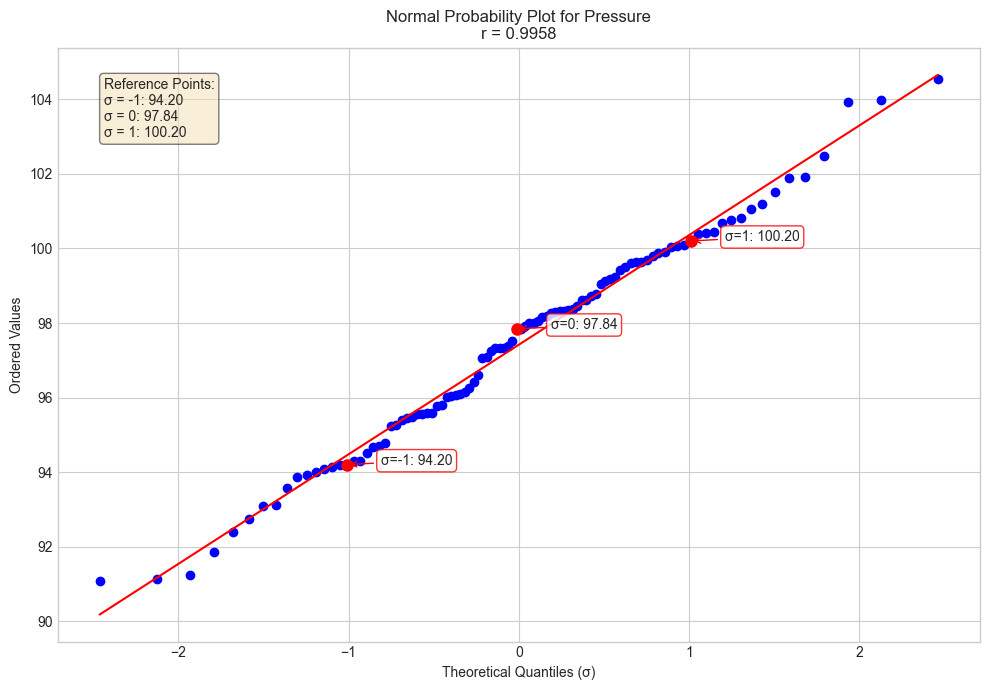

Ordered values at reference points:
σ = -1: 494.1000 (theoretical quantile = -1.0100)
σ = 0: 497.5000 (theoretical quantile = -0.0125)
σ = 1: 502.4000 (theoretical quantile = 1.0100)


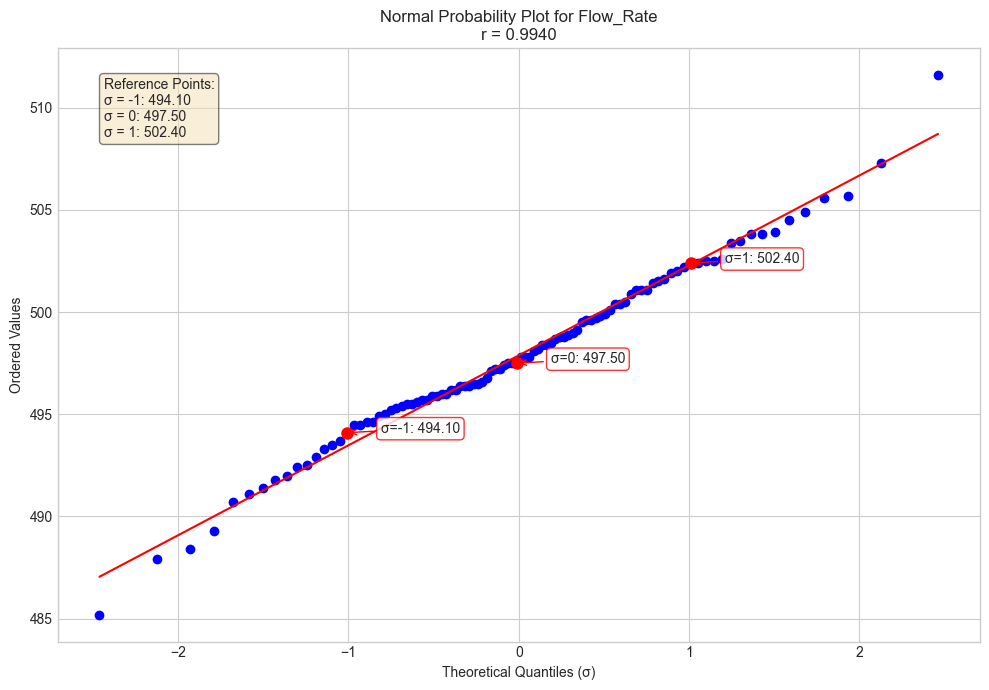

Ordered values at reference points:
σ = -1: 503.3119 (theoretical quantile = -1.0100)
σ = 0: 517.2769 (theoretical quantile = -0.0125)
σ = 1: 534.2758 (theoretical quantile = 1.0100)


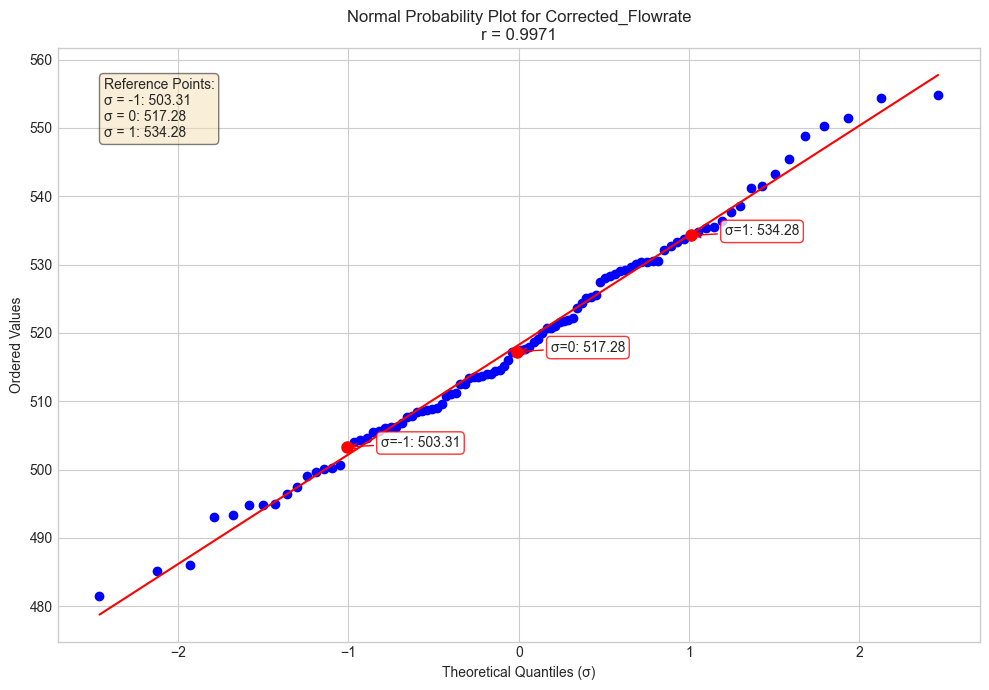

Ordered values at reference points:
σ = -1: 8.9303 (theoretical quantile = -1.0100)
σ = 0: 9.0836 (theoretical quantile = -0.0125)
σ = 1: 9.2317 (theoretical quantile = 1.0100)


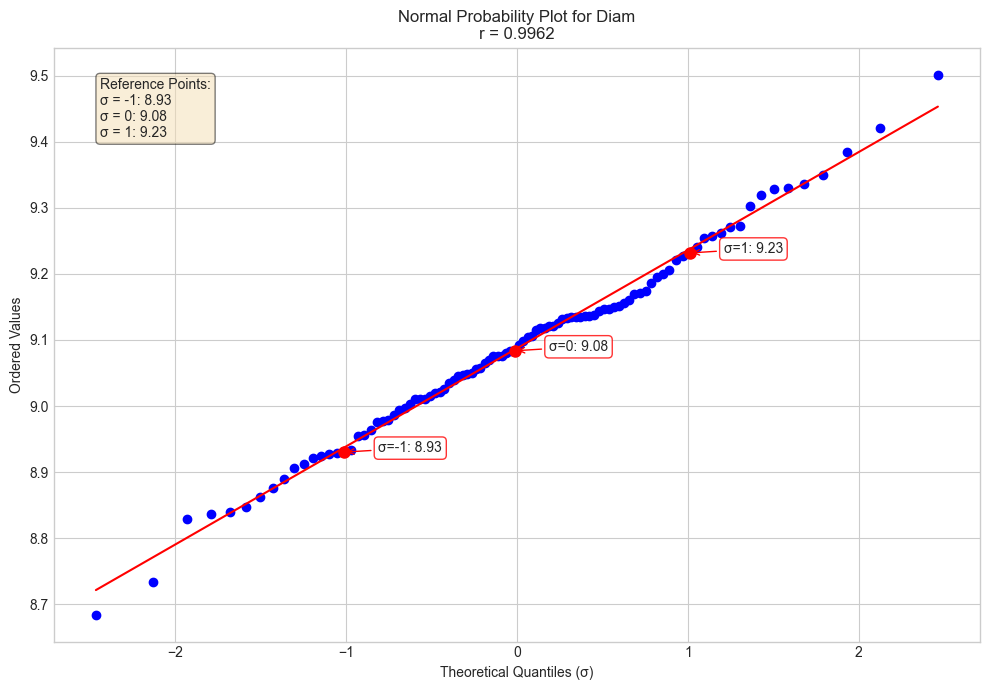

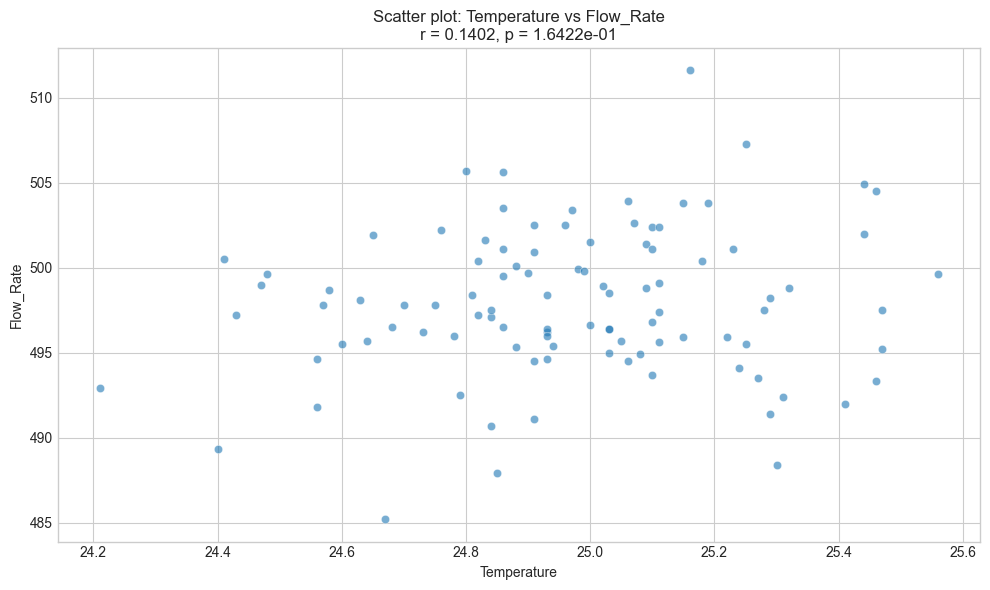

In [80]:
# Correlation analysis between Temperature and Pressure
corr, p_value = pc.calculate_correlation('Temperature', 'Flow_Rate')
print(f"\nCorrelation between Temperature and Pressure:")
print(f"Correlation coefficient: {corr:.4f}")
print(f"p-value: {p_value:.4e}")

# Analyze correlation between multiple columns
columns_of_interest = ['Temperature', 'Pressure', 'Flow_Rate','Corrected_Flowrate','Diam']

# Check if all columns exist in the dataset
available_columns = [col for col in columns_of_interest if col in pc.data.columns]
print(f"\nAnalyzing correlations between: {available_columns}")

# Generate and plot correlation matrix for available columns
pc.plot_correlation_matrix(available_columns)



# Visualize the correlation
pc.plot_correlation('Flow_Rate', 'Corrected_Flowrate')
pc.plot_correlation('Diam', 'Corrected_Flowrate')
pc.plot_correlation('Pressure', 'Corrected_Flowrate')
pc.plot_correlation('Diam', 'Pressure')
pc.plot_correlation('Diam', 'Temperature')
pc.plot_normal_probability('Temperature')
pc.plot_normal_probability('Pressure')
pc.plot_normal_probability('Flow_Rate')
pc.plot_normal_probability('Corrected_Flowrate')
pc.plot_normal_probability('Diam')






# Example of analyzing a specific pair of columns with different visualization
if 'Temperature' in pc.data.columns and 'Flow_Rate' in pc.data.columns:
    pc.plot_correlation('Temperature', 'Flow_Rate', add_line=False)
    